# Generative Adversarial Networks (GANs)

So far in CS231N, all the applications of neural networks that we have explored have been **discriminative models** that take an input and are trained to produce a labeled output. This has ranged from straightforward classification of image categories to sentence generation (which was still phrased as a classification problem, our labels were in vocabulary space and we’d learned a recurrence to capture multi-word labels). In this notebook, we will expand our repetoire, and build **generative models** using neural networks. Specifically, we will learn how to build models which generate novel images that resemble a set of training images.

### What is a GAN?

In 2014, [Goodfellow et al.](https://arxiv.org/abs/1406.2661) presented a method for training generative models called Generative Adversarial Networks (GANs for short). In a GAN, we build two different neural networks. Our first network is a traditional classification network, called the **discriminator**. We will train the discriminator to take images, and classify them as being real (belonging to the training set) or fake (not present in the training set). Our other network, called the **generator**, will take random noise as input and transform it using a neural network to produce images. The goal of the generator is to fool the discriminator into thinking the images it produced are real.

We can think of this back and forth process of the generator ($G$) trying to fool the discriminator ($D$), and the discriminator trying to correctly classify real vs. fake as a minimax game:
$$\underset{G}{\text{minimize}}\; \underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
where $z \sim p(z)$ are the random noise samples, $G(z)$ are the generated images using the neural network generator $G$, and $D$ is the output of the discriminator, specifying the probability of an input being real. In [Goodfellow et al.](https://arxiv.org/abs/1406.2661), they analyze this minimax game and show how it relates to minimizing the Jensen-Shannon divergence between the training data distribution and the generated samples from $G$.

To optimize this minimax game, we will aternate between taking gradient *descent* steps on the objective for $G$, and gradient *ascent* steps on the objective for $D$:
1. update the **generator** ($G$) to minimize the probability of the __discriminator making the correct choice__. 
2. update the **discriminator** ($D$) to maximize the probability of the __discriminator making the correct choice__.

While these updates are useful for analysis, they do not perform well in practice. Instead, we will use a different objective when we update the generator: maximize the probability of the **discriminator making the incorrect choice**. This small change helps to allevaiate problems with the generator gradient vanishing when the discriminator is confident. This is the standard update used in most GAN papers, and was used in the original paper from [Goodfellow et al.](https://arxiv.org/abs/1406.2661). 

In this assignment, we will alternate the following updates:
1. Update the generator ($G$) to maximize the probability of the discriminator making the incorrect choice on generated data:
$$\underset{G}{\text{maximize}}\;  \mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
2. Update the discriminator ($D$), to maximize the probability of the discriminator making the correct choice on real and generated data:
$$\underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$

### What else is there?
Since 2014, GANs have exploded into a huge research area, with massive [workshops](https://sites.google.com/site/nips2016adversarial/), and [hundreds of new papers](https://github.com/hindupuravinash/the-gan-zoo). Compared to other approaches for generative models, they often produce the highest quality samples but are some of the most difficult and finicky models to train (see [this github repo](https://github.com/soumith/ganhacks) that contains a set of 17 hacks that are useful for getting models working). Improving the stabiilty and robustness of GAN training is an open research question, with new papers coming out every day! For a more recent tutorial on GANs, see [here](https://arxiv.org/abs/1701.00160). There is also some even more recent exciting work that changes the objective function to Wasserstein distance and yields much more stable results across model architectures: [WGAN](https://arxiv.org/abs/1701.07875), [WGAN-GP](https://arxiv.org/abs/1704.00028).


GANs are not the only way to train a generative model! For other approaches to generative modeling check out the [deep generative model chapter](http://www.deeplearningbook.org/contents/generative_models.html) of the Deep Learning [book](http://www.deeplearningbook.org). Another popular way of training neural networks as generative models is Variational Autoencoders (co-discovered [here](https://arxiv.org/abs/1312.6114) and [here](https://arxiv.org/abs/1401.4082)). Variatonal autoencoders combine neural networks with variationl inference to train deep generative models. These models tend to be far more stable and easier to train but currently don't produce samples that are as pretty as GANs.

Here's an example of what your outputs from the 3 different models you're going to train should look like... note that GANs are sometimes finicky, so your outputs might not look exactly like this... this is just meant to be a *rough* guideline of the kind of quality you can expect:

![caption](gan_outputs_pytorch.png)

## Setup

In [1]:
import torch
import torch.nn as nn
from torch.nn import init
import torchvision
import torchvision.transforms as T
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

def show_images(images):
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return 

def preprocess_img(x):
    return 2 * x - 1.0

def deprocess_img(x):
    return (x + 1.0) / 2.0

def rel_error(x,y):
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

def count_params(model):
    """Count the number of parameters in the current TensorFlow graph """
    param_count = np.sum([np.prod(p.size()) for p in model.parameters()])
    return param_count

answers = dict(np.load('gan-checks-tf.npz'))

## Dataset
 GANs are notoriously finicky with hyperparameters, and also require many training epochs. In order to make this assignment approachable without a GPU, we will be working on the MNIST dataset, which is 60,000 training and 10,000 test images. Each picture contains a centered image of white digit on black background (0 through 9). This was one of the first datasets used to train convolutional neural networks and it is fairly easy -- a standard CNN model can easily exceed 99% accuracy. 

To simplify our code here, we will use the PyTorch MNIST wrapper, which downloads and loads the MNIST dataset. See the [documentation](https://github.com/pytorch/vision/blob/master/torchvision/datasets/mnist.py) for more information about the interface. The default parameters will take 5,000 of the training examples and place them into a validation dataset. The data will be saved into a folder called `MNIST_data`. 

In [2]:
class ChunkSampler(sampler.Sampler):
    """Samples elements sequentially from some offset. 
    Arguments:
        num_samples: # of desired datapoints
        start: offset where we should start selecting from
    """
    def __init__(self, num_samples, start=0):
        self.num_samples = num_samples
        self.start = start

    def __iter__(self):
        return iter(range(self.start, self.start + self.num_samples))

    def __len__(self):
        return self.num_samples

NUM_TRAIN = 50000
NUM_VAL = 5000

NOISE_DIM = 96
batch_size = 128

# mnist_train = dset.MNIST('./cs231n/datasets/MNIST_data', train=True, download=True,
#                            transform=T.ToTensor())
# loader_train = DataLoader(mnist_train, batch_size=batch_size,
#                           sampler=ChunkSampler(NUM_TRAIN, 0))

mnist_val = dset.MNIST('./cs231n/datasets/MNIST_data', train=True, download=True,
                           transform=T.ToTensor())
loader_val = DataLoader(mnist_val, batch_size=batch_size,
                        sampler=ChunkSampler(NUM_VAL, NUM_TRAIN))


imgs = loader_train.__iter__().next()[0].view(batch_size, 784).numpy().squeeze()
show_images(imgs)

NameError: name 'loader_train' is not defined

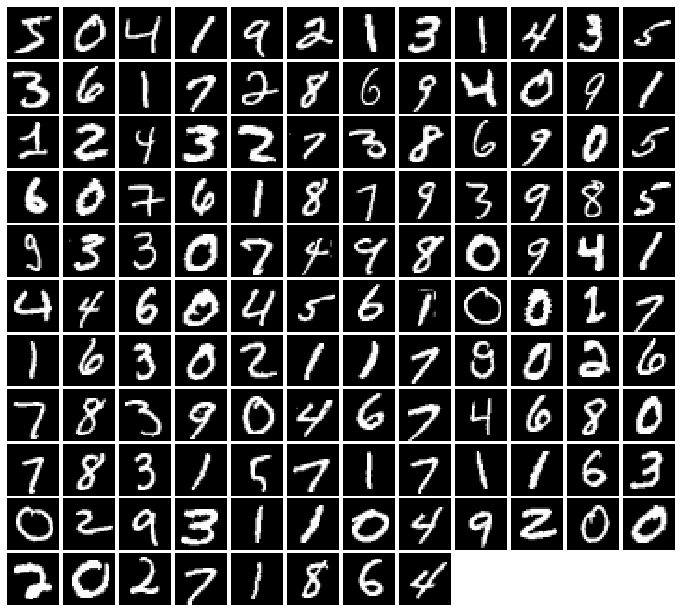

In [3]:
mnist_train = dset.MNIST('./cs231n/datasets/MNIST_data', train=True, download=True,
                           transform=T.ToTensor())
loader_train = DataLoader(mnist_train, batch_size=batch_size,
                          sampler=ChunkSampler(NUM_TRAIN, 0))

imgs = loader_train.__iter__().next()[0].view(batch_size, 784).numpy().squeeze()
show_images(imgs)

In [11]:
dtype = torch.FloatTensor

In [20]:
def sample_noise(batch_size, dim):
    return 2*torch.rand(batch_size, dim) - 1

class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size()
        return x.view(N, -1)

class Unflatten(nn.Module):
    def __init__(self, N, C, H, W):
        super(Unflatten, self).__init__()
        self.N, self.C, self.H, self.W = N, C, H, W
    
    def forward(self, x):
        N, C, H, W = self.N, self.C, self.H, self.W
        return x.view(N, C, H, W)

def initialize_weights(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.ConvTranspose2d):
        init.xavier_uniform_(m.weight.data)
    
def generator(noise_dim=NOISE_DIM):
# Input: some random noise of any shape
# Output: a vector of length 28*28, flattened for the image (value from -1 to 1)
#         after being flattened.
    model = nn.Sequential(
        nn.Linear(noise_dim, 1024),
        nn.ReLU(inplace=True),
        nn.BatchNorm1d(1024),
        nn.Linear(1024, 7*7*128),
        nn.ReLU(inplace=True),
        nn.BatchNorm1d(7*7*128),
        Unflatten(N=-1, C=128, H=7, W=7),
        nn.ConvTranspose2d(128, 64, 4, 2, 1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(64),
        nn.ConvTranspose2d(64, 1, 4, 2, 1),
        nn.Tanh(),
        Flatten()    
    )
    return model

def discriminator():
# Input: flattened real image or flattened fake image from the generator
# Output: a scaler respresenting the probablity of the received input being real
    model = nn.Sequential(
        Unflatten(N=-1, C=1, H=28, W=28),
        nn.Conv2d(1,32,5,1), # -> 24*24
        nn.LeakyReLU(negative_slope=0.01, inplace=True),
        nn.MaxPool2d(2,2), # -> 12*12
        nn.Conv2d(32,64,5,1), # -> 8*8
        nn.LeakyReLU(negative_slope=0.01, inplace=True),
        nn.MaxPool2d(2,2), # -> 4*4
        Flatten(), # -> (N, 64*4*4)
        nn.Linear(64*4*4, 64*4*4),
        nn.LeakyReLU(negative_slope=0.01, inplace=True),
        nn.Linear(64*4*4, 1)
    )
    return model

def bce_loss(input, target):
# Numerically stable binary cross-entropy loss function
    neg_abs = - input.abs()
    loss = input.clamp(min=0) - input * target + (1 + neg_abs.exp()).log()
    return loss.mean()

def generator_loss(logits_fake):
    N, _ = logits_fake.size()
    return bce_loss(logits_fake, torch.ones(N)).type(dtype)

def discriminator_loss(logits_real, logits_fake):
    N, _ = logits_fake.size()
    return bce_loss(logits_real, torch.ones(N)).type(dtype) + bce_loss(logits_fake, torch.zeros(N)).type(dtype)

def get_optimizer(model):
    return optim.Adam(model.parameters(), lr=1e-3, betas=(0.5,0.999))

In [21]:
def run_a_gan(D, G, D_solver, G_solver, discriminator_loss, generator_loss, batch_size=128,
              noise_size=96, show_every=100, num_epoches=2):
    
    iteration = 0
    for epoch in range(num_epoches):
        for x, _ in loader_train:
            if len(x) != batch_size:
                continue
                
            # Discriminator pass - real and fake
            D_solver.zero_grad()
            # real
            real_data = x.type(dtype)
            real_data = 2 * real_data - 1 # maps from [0, -1] domain to [-1, 1] domain
            real_logits = D(real_data).type(dtype)
            # fake
            noise = sample_noise(batch_size, noise_size).type(dtype)
            fake_data = G(noise).detach() # no gradient will be calculated for the generator
            fake_logits = D(fake_data.view(batch_size, 1, 28, 28))
            d_total_error = discriminator_loss(real_logits, fake_logits)
            d_total_error.backward()
            D_solver.step()
            
            # Generator pass - fake only
            G_solver.zero_grad()
            # fake
            noise = sample_noise(batch_size, noise_size).type(dtype)
            fake_data = G(noise)
            fake_logits = D(fake_data.view(batch_size, 1, 28, 28))
            g_error = generator_loss(fake_logits)
            g_error.backward()
            G_solver.step()
            
            iteration += 1
            if iteration % show_every == 0:
                print('Iteration: {}, Epoch: {}, geranator loss: {:.4}, discriminator loss: {:.4}'.format(
                iteration, epoch, g_error.item(), d_total_error.item()))
                imgs_numpy = fake_data.data.cpu().numpy()
                show_images(imgs_numpy[0:16])
                plt.show()
                print()              
            
            

Iteration: 100, Epoch: 0, geranator loss: 0.8425, discriminator loss: 0.9702


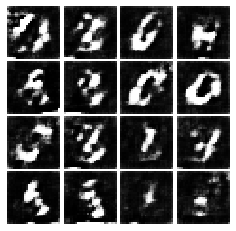


Iteration: 200, Epoch: 0, geranator loss: 0.0513, discriminator loss: 2.023


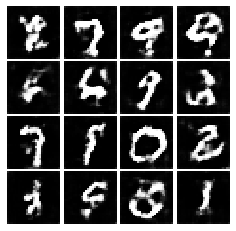


Iteration: 300, Epoch: 0, geranator loss: 1.412, discriminator loss: 0.9878


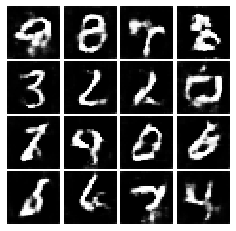


Iteration: 400, Epoch: 1, geranator loss: 1.26, discriminator loss: 1.323


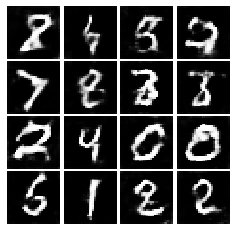


Iteration: 500, Epoch: 1, geranator loss: 0.9232, discriminator loss: 1.16


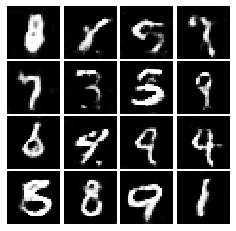


Iteration: 600, Epoch: 1, geranator loss: 1.364, discriminator loss: 1.156


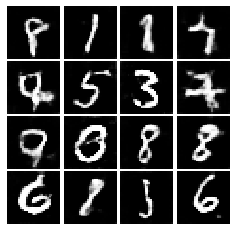


Iteration: 700, Epoch: 1, geranator loss: 0.9756, discriminator loss: 1.11


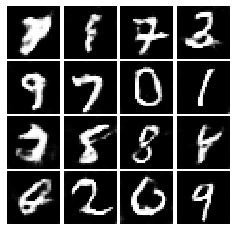

KeyboardInterrupt: 

In [22]:
G = generator(noise_dim=NOISE_DIM).type(dtype)
G.apply(initialize_weights)

D = discriminator().type(dtype)
D.apply(initialize_weights)


G_solver = get_optimizer(G)
D_solver = get_optimizer(D)

run_a_gan(D, G, D_solver, G_solver, discriminator_loss, generator_loss, num_epoches=2)

## INLINE QUESTION 1

We will look at an example to see why alternating minimization of the same objective (like in a GAN) can be tricky business.

Consider $f(x,y)=xy$. What does $\min_x\max_y f(x,y)$ evaluate to? (Hint: minmax tries to minimize the maximum value achievable.)

Now try to evaluate this function numerically for 6 steps, starting at the point $(1,1)$, 
by using alternating gradient (first updating y, then updating x using that updated y) with step size $1$. **Here step size is the learning_rate, and steps will be learning_rate * gradient.**
You'll find that writing out the update step in terms of $x_t,y_t,x_{t+1},y_{t+1}$ will be useful.

Breifly explain what $\min_x\max_y f(x,y)$ evaluates to and record the six pairs of explicit values for $(x_t,y_t)$ in the table below.

### Your answer:

 
 $y_0$ | $y_1$ | $y_2$ | $y_3$ | $y_4$ | $y_5$ | $y_6$ 
 ----- | ----- | ----- | ----- | ----- | ----- | ----- 
   1   |   2   |   1   |   -1  |   -2  |  -1   |   1  
 $x_0$ | $x_1$ | $x_2$ | $x_3$ | $x_4$ | $x_5$ | $x_6$ 
   1   |   -1  |   -2  |   -1  |  1    |  2    |  1    
   




## INLINE QUESTION 2
Using this method, will we ever reach the optimal value? Why or why not?

### Your answer:
No, because after 6 iterations, the x and y become the same values as it started. This pattern will continuous to loop around unless we modify the learning rate.


## INLINE QUESTION 3
If the generator loss decreases during training while the discriminator loss stays at a constant high value from the start, is this a good sign? Why or why not? A qualitative answer is sufficient.

### Your answer:
This is not a good sign. The generator is trained on the feedback from the discriminator. If the feedback is garbage, the generator will not be trained well.